## Pre-Processing Interfaces

#### Values Management Policy
- Lines with duplicate smiles will be dropped in favor of the one with lowest ```Energy_```, unless another
column is provided.
- Lines with ```nan```/missing values are dropped. 

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import pandas as pd
import IPython

def ldf_display(df, nlines=500):
    """Utility function to display large dataframe portions as an html table."""
    txt = ("<iframe " +
           "srcdoc='" + df.head(nlines).to_html() + "' " +
           "width=1000 height=500 style=\"background: #FFFFFF;\">" +
           "</iframe>")
    return IPython.display.HTML(txt)

def prune_dataset_lines(
    dataset: pd.DataFrame, remove_nan_lines: bool = True, remove_nan_cols: bool = False, 
    remove_duplicates_: bool = True, in_favour_of_col: str = 'Energy_(kcal/mol)') -> pd.DataFrame:
    """
    Remove lines from dataset if they contain nan values or are missing values.
    This function does not modify it's parameters.

    Parameters
    -----------
    - dataset the dataset to prune. It is copied inside the function. 
    - remove_nan
    - remove_cols if specified, all columns with nan or empty values will be dropped.
    - remove_duplicates
    - in_favour_of_col
    
    Returns
    -----------
    The pruned DataFrame by copy. 
    """
    pruned_dataset = dataset.copy()
    pruned_dataset.replace("nan", np.nan)
    
    if remove_nan_cols:
        pruned_dataset.dropna(axis=1, how='any', inplace=True)        

    if remove_nan_lines:  
        pruned_dataset.dropna(axis=0, how='any', inplace=True)

    if remove_duplicates_:
        pruned_dataset.sort_values(axis=0, by=['Chiral_Molecular_SMILES', in_favour_of_col], ascending=True, inplace=True)
        pruned_dataset.drop_duplicates(subset='Chiral_Molecular_SMILES', keep='first', inplace=True)
    
    return pruned_dataset

## Smiles Encoding Interface

#### Supported strategies
- One hot encoding (problem : explodes dimensionality)
- Samuel's solutions
- ToDo : Number solution (convert the binary to base10)

In [9]:
def encode_smiles_column_of(dataset: pd.DataFrame, strategy: str = 'one_hot_encoding'):
    """
    Encode smiles string column to numerical representation. 
    This function does not modify it's arguments.

    Parameters
    -----------
    - dataset the dataset to prune. It is copied inside the function. 
    - strategy one of 'one_hot_encoding', 'count_encoding'
    
    Returns
    -----------
    The encoded dataset by copy.
    """
    encoded_dataset = dataset.copy()
    smiles = encoded_dataset['Chiral_Molecular_SMILES']

    if strategy == 'one_hot_encoding':
        encoded_dataset = pd.get_dummies(dataset, columns=['Chiral_Molecular_SMILES'])

    if strategy == 'count_encoding':
        smiles_alphabet = list(set(''.join(np.asanyarray(smiles))))
        for letter in smiles_alphabet:
            encoded_dataset[letter] = encoded_dataset.apply(lambda row: row['Chiral_Molecular_SMILES'].count(letter), axis=1)
        
        del encoded_dataset['Chiral_Molecular_SMILES']

    return encoded_dataset

In [10]:
from sklearn.linear_model import LinearRegression
from utils import load_data
from sklearn.metrics import mean_squared_error
import numpy as np

def normalize_ndarray(X: np.ndarray):
    """Normalize every column of X by substracting mean and dividing by std"""
    for j in range(X.shape[1]):
        if np.std(X[:, j]) != 0: 
            X[:, j] = (X[:, j]-np.mean(X[:, j]))/np.std(X[:, j])
        else:
            X[:, j] = 0
    return X

def return_required_data(dataset: pd.DataFrame, targets: list[str], normalize=True): 
    target_indices = []
    for target in targets:
        target_indices.append(dataset.columns.get_loc(target))

    X_train, X_test = load_data(np.asanyarray(dataset))
    
    y_test = np.ndarray(shape=(X_test.shape[0], len(targets)))
    y_train = np.ndarray(shape=(X_train.shape[0], len(targets)))

    target_indices.sort(reverse=True)
    # remove target columns from X and add them to y
    # with train and test data
    for i, index in enumerate(target_indices):                
        y_train[:, i] = X_train[:, index]
        X_train = np.delete(X_train, index, 1)

        y_test[:, i] = X_test[:, index]
        X_test = np.delete(X_test, index, 1)
    
    if normalize:
        X_train = normalize_ndarray(X_train)
        y_train = normalize_ndarray(y_train)
        X_test = normalize_ndarray(X_test)
        y_test = normalize_ndarray(y_test)

    return X_train, y_train, X_test, y_test

## Baseline

The chosen baseline algorithm is the mean predictor.

In [11]:
class MeanPredictor:
    def __init__(self):
        self.X_train = []
        self.y_train = []
        self.means = []

    def fit(self, X_train, y_train):
        self.means = np.mean(y_train, axis=0)
        return self

    def predict(self, X_test):
        y_pred = np.ndarray(shape=(X_test.shape[0], len(self.means)))
        for j in range(len(self.means)):
            y_pred[:, j] = self.means[j]
        return y_pred 


### Data Pipeline Application

In [12]:
raw_dataset = pd.read_csv('./dataset/data.csv')

pruned_dataset = prune_dataset_lines(raw_dataset, remove_nan_lines=False, remove_nan_cols=True)
print("Raw dataset shape =", raw_dataset.shape, " Pruned dataset shape =", pruned_dataset.shape)

encoded_pruned_data = encode_smiles_column_of(pruned_dataset, 'count_encoding') # change to one_hot_encoding here
print("Encoded dataset shape =", encoded_pruned_data.shape)

X_train, y_train, X_test, y_test = return_required_data(
    encoded_pruned_data, 
    ['Energy_(kcal/mol)', 'Energy DG:kcal/mol)'], 
    normalize=True
)

Raw dataset shape = (39926, 24)  Pruned dataset shape = (12865, 6)
Encoded dataset shape = (12865, 35)


### Linear Regression

In [176]:
LR = LinearRegression()
LR = LR.fit(X_train, y_train)

y_pred_test = LR.predict(X_test)
y_pred_train = LR.predict(X_train)

print("mse y_train, y_pred_train =", mean_squared_error(y_train, y_pred_train))
print("mse y_test, y_pred_test =", mean_squared_error(y_test, y_pred_test))

mse y_train, y_pred_train = 2.7893983568758692e-06
mse y_test, y_pred_test = 0.0010759375409920733


### Multi Layer Perceptron Regression

In [177]:
from sklearn.neural_network import MLPRegressor

MLPR = MLPRegressor(hidden_layer_sizes=(10*X_train.shape[1],), activation='relu', max_iter=1000, tol=1e-6, learning_rate='adaptive')
MLPR = MLPR.fit(X_train, y_train)

y_pred_test = MLPR.predict(X_test)
y_pred_train = MLPR.predict(X_train)

print("mse y_train, y_pred_train =", mean_squared_error(y_train, y_pred_train))
print("mse y_test, y_pred_test =", mean_squared_error(y_test, y_pred_test))

mse y_train, y_pred_train = 0.0003549219687516876
mse y_test, y_pred_test = 0.002612602056124169


### Support Vector Machine Regression

In [178]:
from sklearn.svm import SVR

for target in range(y_train.shape[1]):
    svmr = SVR()
    svmr.fit(X_train, y_train[:, target])
    y_pred_test = svmr.predict(X_test)
    y_pred_train = svmr.predict(X_train)
    print("mse y_train, y_pred_train =", mean_squared_error(y_train[:, target], y_pred_train))
    print("mse y_test, y_pred_test =", mean_squared_error(y_test[:, target], y_pred_test))

mse y_train, y_pred_train = 0.007363240007471541
mse y_test, y_pred_test = 0.016840805504171556
mse y_train, y_pred_train = 0.007340061851269217
mse y_test, y_pred_test = 0.01680279620611454


### PCA and data plotting

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=3)

projected_X_train = pca.fit_transform(X_train)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(projected_X_train.shape)

[0.22033024 0.09092545 0.06878284]
[255.87973087 164.37718882 142.96800904]
(9005, 3)


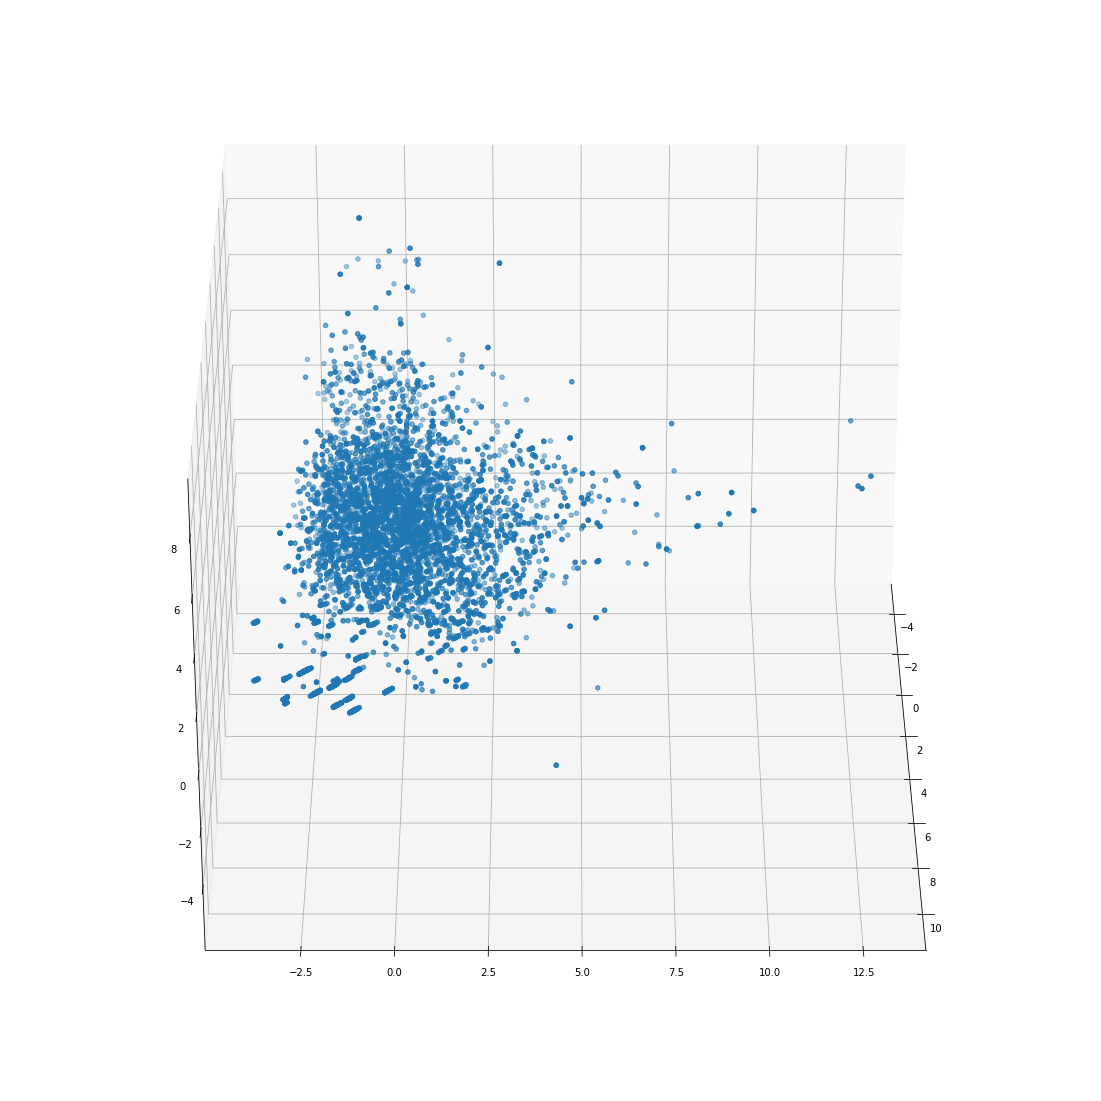

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [20]:
fig = plt.figure(figsize=(20, 20))
plt.ion()
idx = np.random.randint(low=0, high=5000, size=round(projected_X_train.shape[0]))
points_XYZ = projected_X_train[idx, :]

ax = fig.add_subplot(projection='3d')
ax.scatter(points_XYZ[:, 0], points_XYZ[:, 1], points_XYZ[:, 2])
